In [33]:
import os
os.chdir("/content/drive/MyDrive/Colab/Style_transfer")

In [34]:
import numpy as np
import time
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img , img_to_array , save_img
from keras.applications import vgg19
from tensorflow.keras import backend as K
from scipy.optimize import fmin_l_bfgs_b

In [54]:
content_img_path = 'rome.jpg'
style_img_path = 'Pablo_Picasso.jpg'
result_prefix = 'nature_picasso'
iterations = 10

#there are the weights of the different loss compomemts
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

#Dimensions of the generated picture
width , height = load_img(content_img_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height )

#layer name
content_layer = 'block5_conv2'

style_layers = ['block1_conv1' ,
               'block2_conv1' ,
               'block3_conv1' ,
               'block4_conv1' ,
               'block5_conv1']

In [55]:
def preprocess_img(img_path):
  #until function to open , resize and format pictures into appropriate tensors
  img = load_img(img_path , target_size = (img_nrows , img_ncols))
  img = img_to_array(img)
  img = np.expand_dims(img , axis= 0)
  img = vgg19.preprocess_input(img)

  return img

def deprocess_img(x):
  #until function to onvert a tensor into a valid image
  x = x.reshape((img_nrows , img_ncols , 3))
  x[: , : ,0] += 103.939
  x[: , : ,1] += 116.779
  x[: , : ,2] += 123.68

  # 'BGR' -> 'RGB'
  x = x[: , : , : :-1]
  x = np.clip(x ,0 , 255).astype('uint8')

  return x

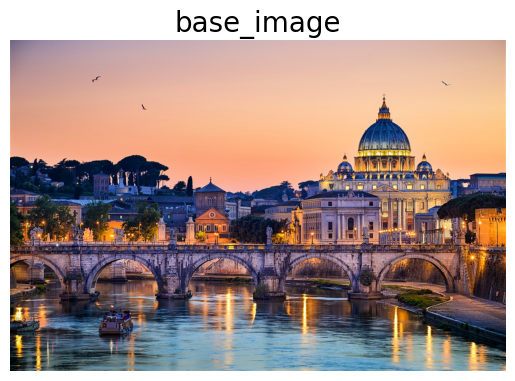

In [56]:
plt.figure()
plt.title('base_image' , fontsize = 20)
img = load_img(content_img_path)
plt.axis('off')
plt.imshow(img);

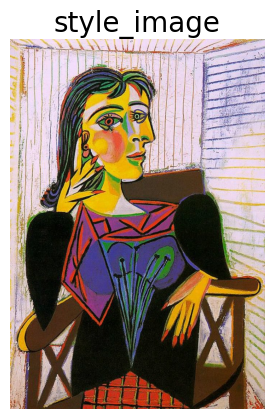

In [57]:
plt.figure()
plt.title('style_image' , fontsize = 20)
img = load_img(style_img_path)
plt.axis('off')
plt.imshow(img);

In [58]:
#get tensor representation
content_img = K.variable(preprocess_img(content_img_path))
style_img = K.variable(preprocess_img(style_img_path))
combination_img = K.placeholder(dtype='float32' , shape=(1 , img_nrows , img_ncols , 3))

input_tensor = K.concatenate((content_img , style_img , combination_img) , axis=0)

input_tensor.shape

TensorShape([3, 400, 599, 3])

In [59]:
#get model
model = vgg19.VGG19(input_tensor = input_tensor , weights = 'imagenet' , include_top = False)

layer_output = {layer.name : layer.output for layer in model.layers}

In [60]:
#compute the neural style loss
#first we need to define 4 util functions
#the Gram matrix of an image tensor (feature-wise other product)
def gram_matrix(x):
  x = K.permute_dimensions(x , (2 , 0 , 1 ))
  features = K.batch_flatten(x)
  gram = K.dot(features , K.transpose(features))

  return gram

In [61]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    width, height, channel = K.int_shape(style)
    s = gram_matrix(style)
    c = gram_matrix(combination)
    loss = K.sum(K.square(s - c)) # / (4.0 * channel**2 * ((width * height)**2))
    return loss

In [62]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

In [63]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
  i = K.square(x[: , :-1 , :-1 , : ] - x[: , 1: , :-1 , :])
  j = K.square(x[: , :-1 , :-1 , : ] - x[: , :-1 , 1: , :])
  loss = K.sum(K.pow(i+j , 1.25))
  return loss

In [64]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
# content loss
layer_features = layer_output[content_layer]
content_feature = layer_features[0, :, :, :]
combination_feature = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(content_feature, combination_feature)

# style loss
for layer_name in style_layers:
    layer_features = layer_output[layer_name]
    style_feature = layer_features[1, :, :, :]
    combination_feature = layer_features[2, :, :, :]
    sl = style_loss(style_feature, combination_feature)
    loss += style_weight * sl / len(style_layers)


# total variation loss
loss = loss + total_variation_weight * total_variation_loss(content_img)

In [65]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss , combination_img)[0]
fetch_grads_loss = K.function([combination_img], [loss, grads])

def eval_grads_loss(x):
  x = x.reshape((1 , img_nrows , img_ncols , 3))
  loss_value , grads_values = fetch_grads_loss([x])
  grads_values = grads_values.flatten().astype('float64')
  return loss_value , grads_values

In [66]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator:
  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self , x):
    assert self.loss_value is None
    self.loss_value , self.grads_values = eval_grads_loss(x)
    return self.loss_value

  def grads(self , x):
    self.loss_value = None
    return self.grads_values

evalator = Evaluator()

In [67]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

x = preprocess_img(content_img_path)

for i in range(iterations):
  print(f"start of iteration {i}")
  start_time = time.time()

  x , min_val , info = fmin_l_bfgs_b(evalator.loss , x.flatten() , fprime=evalator.grads , maxfun = 20)
  img = deprocess_img(x.copy())
  name = result_prefix + f'_at_iteration_{i}.jpg'
  save_img(name , img)
  print(f'Image saved as {name}')
  end_time = time.time()

start of iteration 0
Image saved as nature_picasso_at_iteration_0.jpg
start of iteration 1
Image saved as nature_picasso_at_iteration_1.jpg
start of iteration 2
Image saved as nature_picasso_at_iteration_2.jpg
start of iteration 3
Image saved as nature_picasso_at_iteration_3.jpg
start of iteration 4
Image saved as nature_picasso_at_iteration_4.jpg
start of iteration 5
Image saved as nature_picasso_at_iteration_5.jpg
start of iteration 6
Image saved as nature_picasso_at_iteration_6.jpg
start of iteration 7
Image saved as nature_picasso_at_iteration_7.jpg
start of iteration 8
Image saved as nature_picasso_at_iteration_8.jpg
start of iteration 9
Image saved as nature_picasso_at_iteration_9.jpg


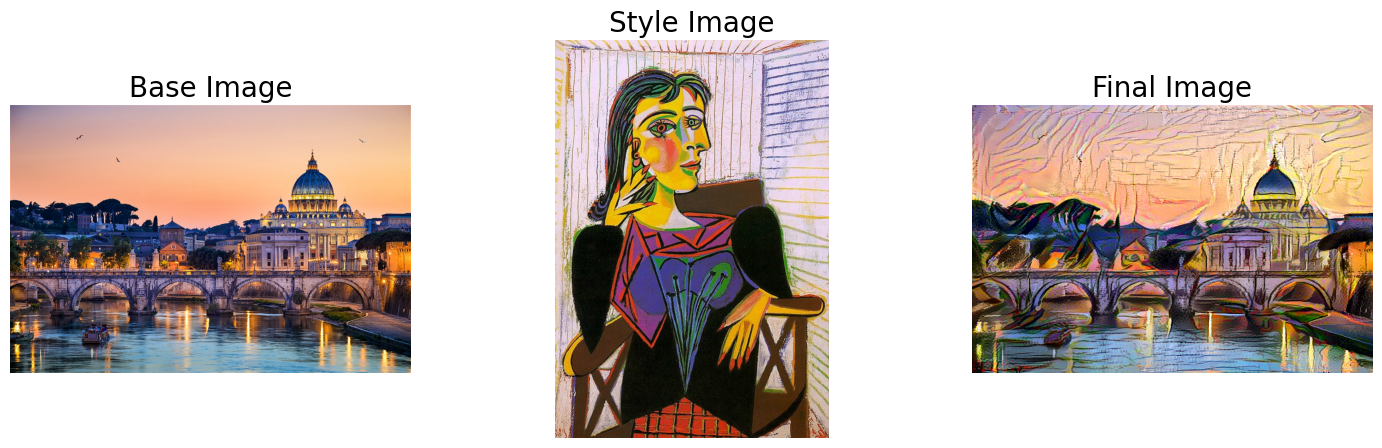

In [68]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_content = load_img(content_img_path)
plt.axis('off')
plt.imshow(img_content)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_img_path)
plt.axis('off')
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.axis('off')
plt.imshow(deprocess_img(x.copy()))